In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
(x_train, y_train),(x_test, y_test)=tf.keras.datasets.cifar10.load_data()
classes=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [3]:
x_train.shape,y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
x_train.min(),x_train.max()

(0, 255)

In [5]:
x_train=x_train/255
x_test=x_test/255
x_train.min(),x_train.max()

(0.0, 1.0)

Text(0.5, 1.0, 'dog')

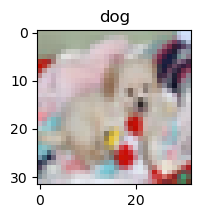

In [6]:
i=np.random.randint(x_train.shape[0])
plt.figure(figsize=(2,2))
plt.imshow(x_train[i])
plt.title(classes[y_train[i][0]])

In [7]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(10,activation="softmax")
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [9]:
model.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

In [10]:
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

c:\Users\Armaan\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 19s 12ms/step - loss: 1.5575 - accuracy: 0.4263 - val_loss: 1.2907 - val_accuracy: 0.5393


In [11]:
model.evaluate(x_train,y_train)

1563/1563 [==============================] - 8s 5ms/step - loss: 1.2724 - accuracy: 0.5408


[1.2724336385726929, 0.5408200025558472]

In [12]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.2907 - accuracy: 0.5393


[1.2907285690307617, 0.5393000245094299]

In [13]:
def plot_random_image(model,images,true_labels,classes=None):
    i=np.random.randint(0,len(images))
    target_image=images[i]
    pred_probs=model.predict(target_image[np.newaxis,:])
    if classes:
        pred_label=classes[pred_probs.argmax()]
        true_label=classes[true_labels[i][0]]
    else:
        pred_label=np.argmax(pred_probs)
        true_label=true_labels[i][0]
    plt.figure(figsize=(3,3))
    plt.imshow(target_image)
    if pred_label==true_label:
        color="green"
    else:
        color="red"
    plt.xlabel("Pred:{} {:2.0f}% (True:{})".format(pred_label,100*tf.reduce_max(pred_probs),true_label),color=color)


1/1 [==============================] - 0s 112ms/step


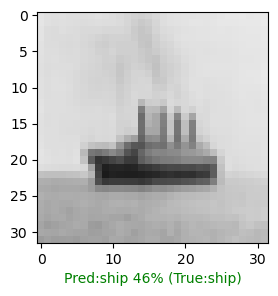

In [14]:
plot_random_image(model,images=x_test,true_labels=y_test,classes=classes)

In [15]:
import itertools

def make_confusion_matrix(y_true,y_pred,classes=None,figsize=(10,10),text_size=8):
    cm=confusion_matrix(y_true,y_pred)
    cm_norm=cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    n_classes=cm.shape[0]

    fig,ax=plt.subplots(figsize=figsize) 
    cax=ax.matshow(cm,cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels=classes
    else:
        labels=np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",xlabel="Predicted Label",ylabel="True Label",
        xticks=np.arange(n_classes),yticks=np.arange(n_classes),
        xticklabels=labels,yticklabels=labels)

    ax.title.set_size(20)

    threshold=(cm.max()+cm.min())/2

    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,f"{cm[i,j]}({cm_norm[i,j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i,j]>threshold else "black",
                size=text_size)

In [16]:
y_pred=model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


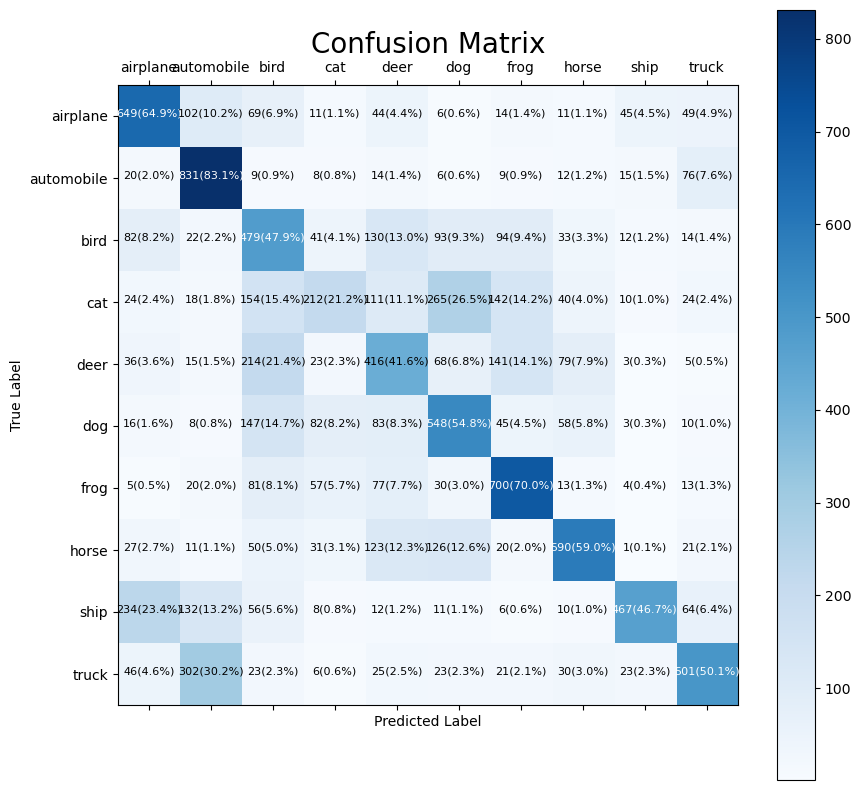

In [17]:
make_confusion_matrix(np.ravel(y_test),np.argmax(y_pred,axis=1),classes=classes)

# Data Augmentation

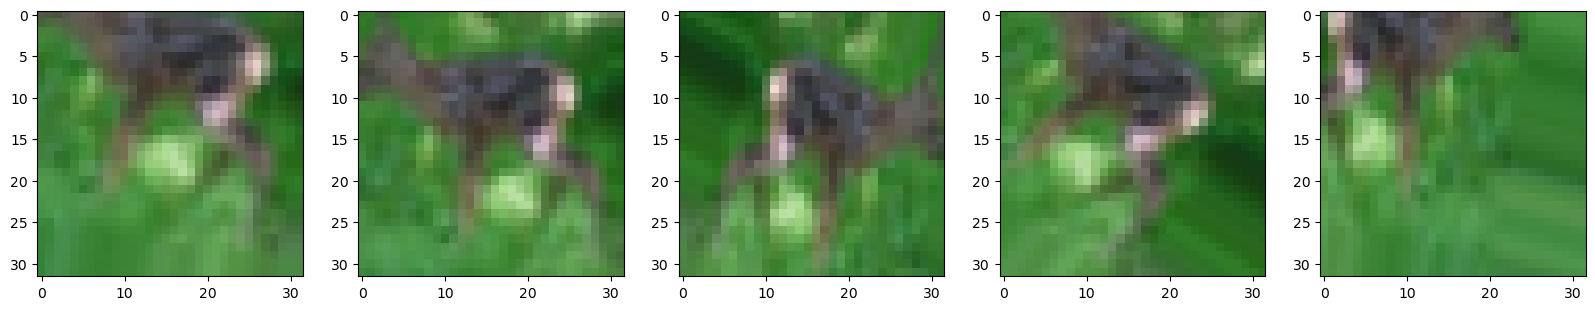

In [18]:
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode="nearest")

test_img=x_train[np.random.randint(x_test.shape[0])]
img=image.img_to_array(test_img)
img=img.reshape((1,)+img.shape)
i=0
plt.figure(figsize=(20,20))
for batch in datagen.flow(img,save_prefix="test",save_format="jpeg"):
    plt.subplot(5,5,i+1)
    plt.imshow(image.img_to_array(batch[0]))
    i+=1
    if i>4:
        break
plt.show()

In [19]:
base_model=tf.keras.applications.MobileNetV2(input_shape=(32,32,3),include_top=False)

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [21]:
base_model.trainable=False

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [23]:
# instead of flattening the feature map of the base layer, we will use global average pooling layer that will average the 1*1 area of each 2D feature 
# map and return a single 1280 element vector.
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()

In [24]:
prediction_layer=tf.keras.layers.Dense(10)

In [25]:
model2=tf.keras.Sequential([base_model,
                            # global_average_layer,
                            prediction_layer])

In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, 1, 1, 10)          12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
model2.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.01),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])  

In [28]:
model2.evaluate(x_test,y_test)

313/313 [==============================] - 8s 21ms/step - loss: 2.3189 - accuracy: 0.1002


[2.3189303874969482, 0.10022079944610596]

In [29]:
history=model2.fit(x_train,y_train,epochs=10)

Epoch 1/10
1563/1563 [==============================] - 32s 19ms/step - loss: 1.9469 - accuracy: 0.1059
Epoch 2/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.9465 - accuracy: 0.1071
Epoch 3/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.9702 - accuracy: 0.1070
Epoch 4/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.9843 - accuracy: 0.1071
Epoch 5/10
1563/1563 [==============================] - 34s 21ms/step - loss: 1.9981 - accuracy: 0.1071
Epoch 6/10
1563/1563 [==============================] - 40s 26ms/step - loss: 2.0107 - accuracy: 0.1070
Epoch 7/10
1563/1563 [==============================] - 38s 24ms/step - loss: 2.0210 - accuracy: 0.1071
Epoch 8/10
1563/1563 [==============================] - 38s 24ms/step - loss: 2.0287 - accuracy: 0.1070
Epoch 9/10
1563/1563 [==============================] - 33s 21ms/step - loss: 2.0359 - accuracy: 0.1069
Epoch 10/10
1563/1563 [==============================] - 34s 22m